<a href="https://colab.research.google.com/github/Jack3690/INSIST/blob/main/PSF_Simulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Installs**

In [1]:
!pip install hcipy --upgrade --quiet

     |████████████████████████████████| 190 kB 5.5 MB/s 
     |████████████████████████████████| 243 kB 51.8 MB/s 
     |████████████████████████████████| 513 kB 55.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 56 kB 3.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nbclient 0.5.9 requires jupyter-client>=6.1.5, but you have jupyter-client 5.3.5 which is incompatible.


In [2]:
!pip install --force-reinstall jsonschema==3.2.0 --quiet

     |████████████████████████████████| 119 kB 5.3 MB/s 
     |████████████████████████████████| 60 kB 5.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nbclient 0.5.9 requires jupyter-client>=6.1.5, but you have jupyter-client 5.3.5 which is incompatible.
google-colab 1.0.0 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
arviz 0.11.4 requires typing-extensions<4,>=3.7.4.3, but you have typing-extensions 4.0.1 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [3]:
!pip install git+https://github.com/rlwastro/mastcasjobs@master --quiet

In [4]:
!pip install photutils --quiet

     |████████████████████████████████| 826 kB 5.2 MB/s 


Run above cells and restart runtime. Continue to run the cells below.

# **Imports**

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.stats import gaussian_fwhm_to_sigma, gaussian_sigma_to_fwhm
from astropy.modeling import models, fitting
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy import wcs
from astropy.io import fits
from astropy.convolution import Gaussian2DKernel, convolve

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.gridspec as gridspec

from photutils.aperture import aperture_photometry
from photutils.aperture import CircularAperture

import os
from time import perf_counter
import json
import requests

import mastcasjobs
from hcipy import *

# get the WSID and password if not already defined
if not os.environ.get('CASJOBS_USERID'):
    os.environ['CASJOBS_USERID'] = "avinashck90"
if not os.environ.get('CASJOBS_PW'):
    os.environ['CASJOBS_PW'] = "INSIST369"

sb.set_style('dark')
matplotlib.rcParams['font.size']=12
matplotlib.rcParams['figure.figsize']=(10,10)

# **Single PSF Generator**

Enter FWHM of source in arcsecond : 0.2
Enter AB magnitude of the source  : 0


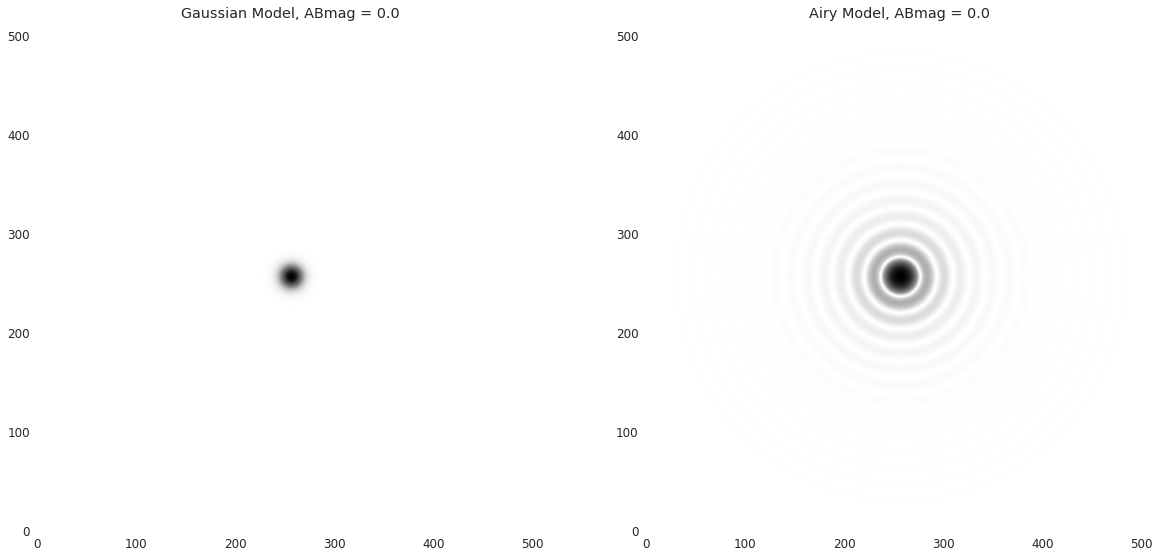

In [ ]:
fwhm_in = float(input("Enter FWHM of source in arcsecond : ") or "0.3")
ABmag = float(input("Enter AB magnitude of the source  : ") or "0")

# Flux to AB magnitude
flux = 3631*pow(10,-ABmag/2.5)

pixel_scale = 0.01 #arcsecond

# Input FWHM to detector fwhm conversion
fwhm = fwhm_in/pixel_scale    

# fwhm to sigma conversion
sigma_psf = fwhm*gaussian_fwhm_to_sigma

# Amplitude of a gaussian for given flux and standard deviation.
amplitude_g = flux/(sigma_psf**2*2*np.pi)

amplitude_a = (flux)/(0.8569446798286412*fwhm**2)

# Number of pixels.
n_pix = 512
y, x  = np.mgrid[0:(n_pix), 0:(n_pix)]

# Modelling a 2D gaussian at the center of the image.
model_gauss = models.Gaussian2D(amplitude_g, len(x)//2, len(x)//2, sigma_psf, sigma_psf)

# Modelling a Airy Disk of same amplitude.
model_airy = models.AiryDisk2D(amplitude_a, len(x)//2, len(x)//2, fwhm)

image_g = model_gauss(x,y)

image_a = model_airy(x,y)

# Plot
fix, ax = plt.subplots(1,2,figsize=(20,10))

norm = ImageNormalize(stretch=LogStretch())

ax[0].imshow(np.log10(1+image_g/image_g.max()),origin='lower',cmap='Greys',vmin=1e-11)
ax[0].set_title(f'Gaussian Model, ABmag = {ABmag}')

ax[1].imshow(image_a,origin='lower',cmap='Greys',norm=norm)
ax[1].set_title(f'Airy Model, ABmag = {ABmag}');

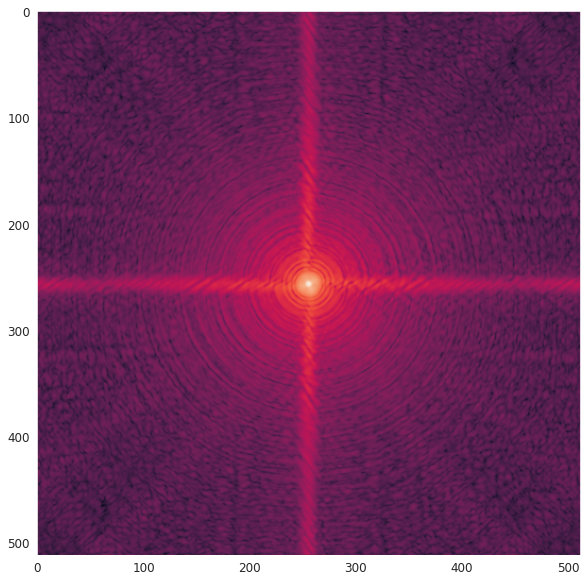

In [ ]:
on_axis_ssr = np.loadtxt('on_axis1.TXT',skiprows=18,encoding='latin-1')
plt.imshow(np.log10(on_axis_ssr/on_axis_ssr.max()))

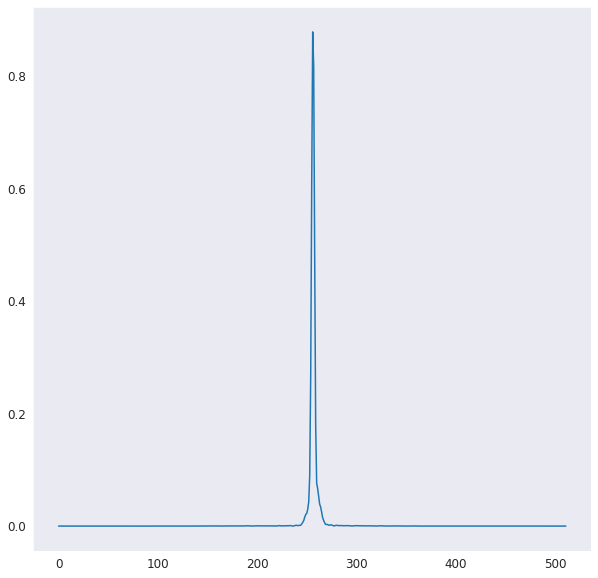

In [ ]:
plt.plot(on_axis_ssr[:,len(on_axis_ssr)//2])

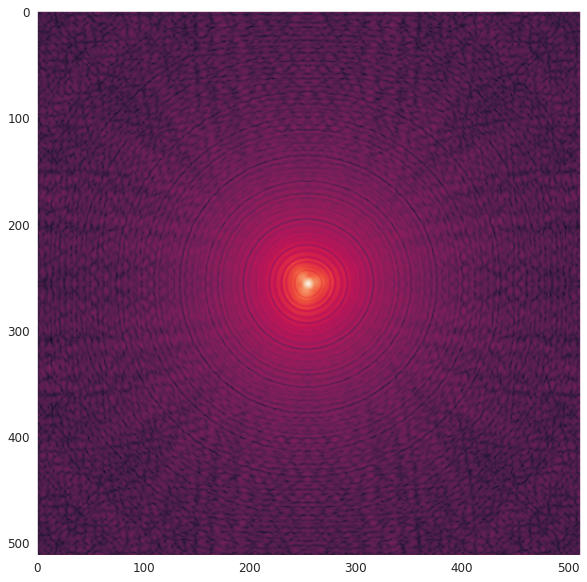

In [ ]:
off_axis_ssr = np.loadtxt('off_axis.TXT',skiprows=18,encoding='latin-1')
plt.imshow(np.log10(off_axis_ssr/off_axis_ssr.max()))

In [ ]:
image_g.sum(), flux, image_a.sum()

Airy Disk not modelled properly yet

# **PSF Generator using Source Catalog**


In [3]:
!git clone https://github.com/Jack3690/INSIST

Cloning into 'INSIST'...
remote: Enumerating objects: 540, done.
remote: Counting objects: 100% (165/165), done.
remote: Compressing objects: 100% (161/161), done.
remote: Total 540 (delta 86), reused 4 (delta 2), pack-reused 375
Receiving objects: 100% (540/540), 61.20 MiB | 26.14 MiB/s, done.
Resolving deltas: 100% (274/274), done.


In [4]:
cd INSIST/data

/content/INSIST/data


### **M 67 GALEX NUV**

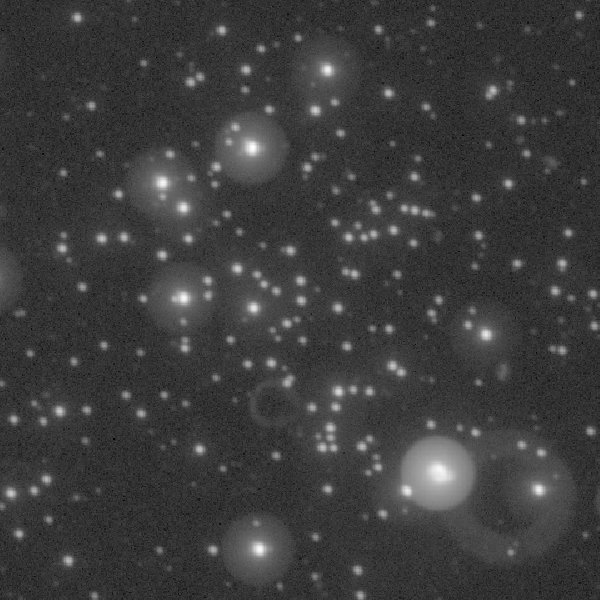

## **GALEX Data**

In [ ]:
df = pd.read_csv('M67.csv')
df = df.rename(columns={'ra':'RA','dec':'Dec'}).drop_duplicates(['RA','Dec'])
df 

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.scatter(df['RA'],df['Dec'],marker='.',color='black')
ax.set_title(f'Sky Plane Distribution | {len(df)} sources')
ax.set_xlabel('RA (Degrees)')
ax.set_ylabel('Dec (Degrees)')
ax.invert_xaxis()

In [ ]:
if df['RA'].max()+df['RA'].min() < 360:
  cen_ra = (df['RA'].max()+df['RA'].min())/2
else :
  cen_ra = (df['RA'].max()+df['RA'].min()-360)/2

cen_dec = (df['Dec'].max()+df['Dec'].min())/2

## **Creating WCS object**

In [ ]:
n_pix_main = 8000
n_pix_sub = 200
pixel_scale = 0.1 #arcsecond

w = wcs.WCS(naxis=2)
w.wcs.crpix = [n_pix_main//2,n_pix_main//2]
w.wcs.cdelt = np.array([-pixel_scale/3600, pixel_scale/3600])
w.wcs.crval = [cen_ra, cen_dec]
w.wcs.ctype = ["RA---TAN", "DEC--TAN"]

## **RA Dec cut based of FoV**

In [ ]:
field_ra_min  = cen_ra  - 0.5*n_pix_main*pixel_scale/3600 + 0.5*n_pix_sub*pixel_scale/3600
field_ra_max  = cen_ra  + 0.5*n_pix_main*pixel_scale/3600 - 0.5*n_pix_sub*pixel_scale/3600
field_dec_min = cen_dec - 0.5*n_pix_main*pixel_scale/3600 + 0.5*n_pix_sub*pixel_scale/3600
field_dec_max = cen_dec + 0.5*n_pix_main*pixel_scale/3600 - 0.5*n_pix_sub*pixel_scale/3600

df_field = df[(df['RA']>field_ra_min) &(df['RA']<field_ra_max) &(df['Dec']>field_dec_min) &(df['Dec']<field_dec_max)]

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.scatter(df_field['RA'],df_field['Dec'],marker='.',color='black')
ax.set_title(f"Distribution on Detector | {len(df)} sources")
ax.set_xlim(field_ra_min,field_ra_max )
ax.set_ylim(field_dec_min ,field_dec_max )
ax.invert_xaxis()
ax.set_xlabel('RA (Degrees)')
ax.set_ylabel('Dec (Degrees)')

## **Adding PSF at coordinates normalized by ABmag**



In [ ]:
image_g_main= np.zeros((n_pix_main,n_pix_main))
f=[]
for i, row in df_field.iterrows():

  c= SkyCoord(row['RA'],row['Dec'],unit=u.deg)
  pix = w.world_to_array_index(c)

  fwhm_in = 1.8 # arcseconds

  ABmag = row['mag_nuv']

  flux = 3631*10**(-ABmag/2.5)
  f.append(flux)

  # Input FWHM based on pixel scale
  fwhm = fwhm_in/pixel_scale    

  sigma_psf = fwhm*gaussian_fwhm_to_sigma

  amplitude = flux/(sigma_psf**2*2*np.pi)

  # Creating 2D Gaussian
  model_gauss = models.Gaussian2D(amplitude,n_pix_sub//2 , n_pix_sub//2 , sigma_psf, sigma_psf)
  y, x  = np.mgrid[0:(n_pix_sub), 0:(n_pix_sub)]

  # Patch with generated Gaussian
  image_g_sub = model_gauss(x,y)

  # Adding the patch to the image
  image_g_main[pix[0]-n_pix_sub//2:pix[0]+n_pix_sub//2,pix[1]-n_pix_sub//2:pix[1]+n_pix_sub//2]+=image_g_sub

In [ ]:
np.array(f).sum(),image_g_main.sum()  # Checking if flux is conserved

Can simulate 2D gaussians of 21702 sources in 50s

In [ ]:
norm = ImageNormalize(stretch=LogStretch())

fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(projection=w)
ax.patch.set_edgecolor('black')  

ax.patch.set_linewidth('3')  
img = ax.imshow(image_g_main,cmap='Greys',vmin = 1e-11,vmax = 5.5e-9 )
ax.set_title(f'M 67 with UVIT | FWHM = {fwhm_in} arcsecs');


# **PSF using CasJobs**

## **Query Script**

In [ ]:
def mastQuery(request, json_return=False):
    """Perform a MAST query.

    Parameters
    ----------
    request (dictionary): The MAST request json object
    
    Returns the text response or (if json_return=True) the json response
    """
    
    url = "https://mast.stsci.edu/api/v0/invoke"

    # Encoding the request as a json string
    requestString = json.dumps(request)
    
    # make the query
    r = requests.post(url, data=dict(request=requestString))
    
    # raise exception on error
    r.raise_for_status()
    
    if json_return:
        return r.json()
    else:
        return r.text


def resolve(name):
    """Get the RA and Dec for an object using the MAST name resolver
    
    Parameters
    ----------
    name (str): Name of object

    Returns RA, Dec tuple with position"""

    resolverRequest = {'service':'Mast.Name.Lookup',
                       'params':{'input':name,
                                 'format':'json'
                                },
                      }
    resolvedObject = mastQuery(resolverRequest, json_return=True)
    # The resolver returns a variety of information about the resolved object, 
    # however for our purposes all we need are the RA and Dec
    try:
        objRa = resolvedObject['resolvedCoordinate'][0]['ra']
        objDec = resolvedObject['resolvedCoordinate'][0]['decl']
    except IndexError as e:
        raise ValueError("Unknown object '{}'".format(name))
    return (objRa, objDec)

In [ ]:
class PSF_gen():
    """PSF Generator using Source catalog or CasJobs GALEX Catalog

    Parameters
    ----------
    name (string) : Catalog name or coordinates of the source

    df   (pd.DataFrame ): Pandas dataframe with source catalog

    cols (dict) : dict object with column name conversions for ra,dec,mag_nuv. Eg {'RA': 'ra','Dec' : 'dec', 'ABmag' : 'mag_nuv'}

        'ra' (degrees)

        'dec' (degrees)

        'mag_nuv' (ABmag)

    pixel_scale (float) : pixel scale of detector in the unit of arcseconds/pixels

    fwhm_in (float) : Full Width at Half Maximum of the Gaussian PSF

    n_pix_main (int) : Number of pixels along one axis in the detector. Total number of pixels in the detector is n_pix_main**2

    n_pix_sub (int) : Number of pixels along one axis in the path. Total number of pixels in the patch is n_pix_sub**2

    """
    def __init__(self,name = None, df = None, cols = None, pixel_scale=0.1,fwhm_in=0.3,n_pix_main=8000,n_pix_sub=200):   

        self.pixel_scale = pixel_scale
        self.fwhm = fwhm_in/pixel_scale
        self.n_pix_main = n_pix_main
        self.n_pix_sub = n_pix_sub

        if name is not None and df is None:
          self.name = name
          self.ra,self.dec = resolve(name)
      
          self.jobs = mastcasjobs.MastCasJobs(context="GALEX_Catalogs")
          self.query =   f"""SELECT ra,dec, mag_nuv,mag_fuv 
                              FROM
                              gcat_asc
                              WHERE
                              ra BETWEEN {self.ra} -0.1 AND {self.ra}+0.1
                              AND 
                              dec BETWEEN {self.dec}-0.1 AND {self.dec}+0.1
                          """
          self.df = self.jobs.quick(self.query, task_name="python cone search").to_pandas()
        else: 
          if cols is not None:
            self.df = df.rename(columns = cols) 
          else :
            self.df =  df
          self.ra = (self.df['ra'].max()+self.df['ra'].min())/2
          self.dec = (self.df['dec'].max()+self.df['dec'].min())/2
          self.name = f" RA : {np.round(self.ra,3)} degrees, Dec : {np.round(self.dec,3)} degrees"
        self.wcs = self.create_wcs()
        self.df_field = self.create_field()
        self.image = None
        
    def create_wcs(self):
      """
      Function for creating WCS object for given ra and dec of a field or a catalog using pixel scale and n_pix_main
      """
      w = wcs.WCS(naxis=2)
      w.wcs.crpix = [self.n_pix_main//2,self.n_pix_main//2]
      w.wcs.cdelt = np.array([self.pixel_scale/3600, self.pixel_scale/3600])
      w.wcs.crval = [self.ra, self.dec]
      w.wcs.ctype = ["RA---TAN", "DEC--TAN"]
      return w

    def create_field(self):
      """
      Function for selecting sources within a box field. The box field size depends on n_pix_main, pixel_scale and n_pix_sub
     """
      field_ra_min  = self.ra  - 0.5*self.n_pix_main*self.pixel_scale/3600 + 0.5*self.n_pix_sub*self.pixel_scale/3600
      field_ra_max  = self.ra  + 0.5*self.n_pix_main*self.pixel_scale/3600 - 0.5*self.n_pix_sub*self.pixel_scale/3600
      field_dec_min = self.dec - 0.5*self.n_pix_main*self.pixel_scale/3600 + 0.5*self.n_pix_sub*self.pixel_scale/3600
      field_dec_max = self.dec + 0.5*self.n_pix_main*self.pixel_scale/3600 - 0.5*self.n_pix_sub*self.pixel_scale/3600

      df_field = self.df[(self.df['ra']>field_ra_min) &(self.df['ra']<field_ra_max) &(self.df['dec']>field_dec_min) &(self.df['dec']<field_dec_max)]
      return df_field
    
    def show_field(self,figsize=(10,10)):
      """
      Function for creating a scatter plot of sources within the FoV
      
      Returns
      -------
      fig, ax
      """
        
      fig, ax = plt.subplots(1,1,figsize=figsize)
      ax.scatter(self.df_field['ra'],self.df_field['dec'],marker='.',color='black')
      ax.set_title(f" Requested Center : {self.name} \n FoV : {np.round(self.pixel_scale*self.n_pix_main/3600,3)} degrees | {len(self.df_field)} sources")
      ax.invert_xaxis()
      ax.set_xlabel('RA (Degrees)')
      ax.set_ylabel('Dec (Degrees)')
      return fig,ax
      
    def generate_psf(self):
      """
      This function creates PSFs based on ABmag and FWHM which  on a small patch (2D array) of size n_pix_sub*n_pix_sub. 
      The patch with the PSF is then added to the image array of size n_pix_main*n_pix_sub using wcs object.
      """
      n_pix_sub = self.n_pix_sub
      image_g_main = np.zeros((self.n_pix_main,self.n_pix_main))
      f=[]
      for i, row in self.df_field.iterrows():
          c = SkyCoord(row['ra'],row['dec'],unit=u.deg)
          pix = self.wcs.world_to_array_index(c)

          ABmag = row['mag_nuv']
          flux = 3631*10**(-ABmag/2.5)
          f.append(flux)     
          sigma_psf = self.fwhm*gaussian_fwhm_to_sigma

          amplitude = flux/(sigma_psf**2*2*np.pi)
          model_gauss = models.Gaussian2D(amplitude,n_pix_sub//2 , n_pix_sub//2 , sigma_psf, sigma_psf)
          y, x  = np.mgrid[0:(n_pix_sub), 0:(n_pix_sub)]

          image_g_sub = model_gauss(x,y)

          image_g_main[pix[0]-n_pix_sub//2:pix[0]+n_pix_sub//2,pix[1]-n_pix_sub//2:pix[1]+n_pix_sub//2]+=image_g_sub
      if np.round(np.array(f).sum(),4)!= np.round(image_g_main.sum(),4):
          print("Patch width is too small")
      self.image = image_g_main
        
    def show_image(self):
      """
      Function for plotting the simulated field with PSFs
      
      Returns
      -------
      fig, ax
      """
      if np.all(self.image) !=None:
          fig = plt.figure(figsize = (15,10))
          ax = fig.add_subplot(projection=self.wcs)
          image = self.image.astype(np.float32)
          norm = ImageNormalize(stretch=LogStretch())

          ax.imshow(image,cmap='gray',vmin = 1e-11,vmax = 5.5e-9 )  #
          ax.set_title(f'Requested center : {self.name}\n Pixel Scale : {self.pixel_scale} | FWHM = {self.fwhm*self.pixel_scale} arcsecs')
          ax.invert_xaxis()
          return fig,ax
      else:
          print("Generate PSF")
    def writeto(self,name):
      """
      Function for downloading a fits file of simulated field
      """
      if np.all(self.image) !=None:
          hdu = fits.PrimaryHDU(self.image)
          hdu.wcs= self.wcs
          hdul = fits.HDUList([hdu])
          hdul.writeto(f'{name}.fits')
      else:
          print("Generate PSF")


## **Query**

In [ ]:
#df = pd.read_csv('M67.csv')

In [ ]:
name = input("Source name (Eg. M 67, 06h 03m 20s 42 18 00) : ") or "M 67"
pixel_scale = float(input("Pixel scale (arcseconds/pixel) : ") or "0.1")
fwhm_in = float(input("FWHM in arcseconds : " )or "0.3")

In [ ]:
psf = PSF_gen(name, pixel_scale = pixel_scale, fwhm_in =fwhm_in)
psf.generate_psf()
psf.show_field()

In [ ]:
psf.show_image()

# **HCIPy**

## **Circular Aperture with obstruction**

**INSIST** 

Primary      : 1     m

Secondary    : 0.36  m

Spider Width : 0.025 m

$F_{eff}$    : 20    m

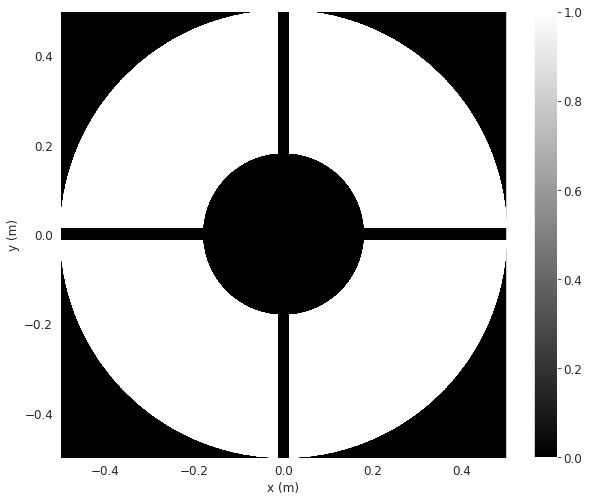

In [ ]:
pupil_diameter         = 1.0 # m
effective_focal_length = 20 # m
secondary_ratio        = 0.36
spider_width           = 0.025

pupil_grid = make_pupil_grid(2000, diameter = pupil_diameter)

aperture        = make_obstructed_circular_aperture(pupil_diameter, secondary_ratio, num_spiders=4, spider_width = spider_width )
telescope_pupil = evaluate_supersampled(aperture , pupil_grid  ,8)

im = imshow_field(telescope_pupil, cmap='gray')
plt.colorbar(shrink=0.82)
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()

In [ ]:
flux = 1

In [ ]:
focal_total = 0

for wavelength in np.linspace(150,300,10)*1e-9:

  amplitude = (flux*wavelength/67911.10303309708)**0.5    # Empirical Intensity scaling 

  wavefront = Wavefront(amplitude*telescope_pupil,wavelength)

  focal_grid = make_focal_grid(q=4, num_airy=128,pupil_diameter=pupil_diameter, focal_length=effective_focal_length, reference_wavelength=wavelength)

  prop = FraunhoferPropagator( pupil_grid, focal_grid, focal_length=effective_focal_length)
  
  focal_image = prop.forward(wavefront)
  focal_total += focal_image.intensity.shaped

In [ ]:
focal_image.amplitude.shaped.shape

(1024, 1024)

In [ ]:
off_axis = np.array(focal_total/10)
off_axis.sum()

1.7829382068180835

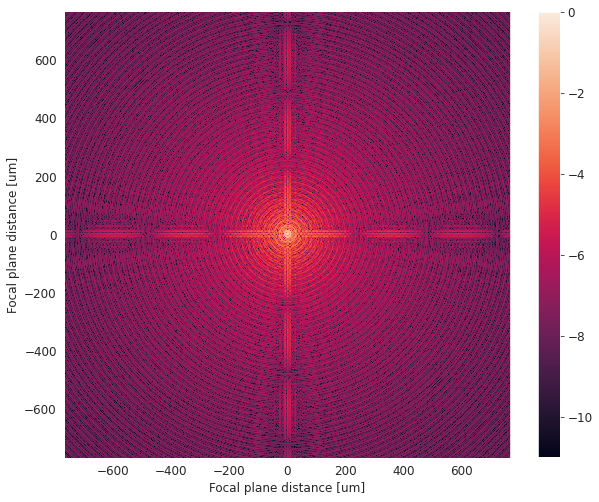

In [ ]:
img = imshow_field(np.log10(focal_image.intensity/focal_image.intensity.max()), vmin=-11, grid_units=1e-6)
plt.xlabel('Focal plane distance [um]')
plt.ylabel('Focal plane distance [um]')
plt.colorbar(shrink=0.82)
plt.show()

In [ ]:
plt.plot(focal_image.intensity.shaped[:,150])

In [ ]:
plt.imshow(focal_image.intensity.shaped,vmin=1e-12,vmax=1e-5)

## **PSF Generator with CasJobs and HCIPy**

In [ ]:
def mastQuery(request, json_return=False):
    """Perform a MAST query.

    Parameters
    ----------
    request (dictionary): The MAST request json object
    
    Returns the text response or (if json_return=True) the json response
    """
    
    url = "https://mast.stsci.edu/api/v0/invoke"

    # Encoding the request as a json string
    requestString = json.dumps(request)
    
    # make the query
    r = requests.post(url, data=dict(request=requestString))
    
    # raise exception on error
    r.raise_for_status()
    
    if json_return:
        return r.json()
    else:
        return r.text


def resolve(name):
    """Get the RA and Dec for an object using the MAST name resolver
    
    Parameters
    ----------
    name (str): Name of object

    Returns RA, Dec tuple with position"""

    resolverRequest = {'service':'Mast.Name.Lookup',
                       'params':{'input':name,
                                 'format':'json'
                                },
                      }
    resolvedObject = mastQuery(resolverRequest, json_return=True)
    # The resolver returns a variety of information about the resolved object, 
    # however for our purposes all we need are the RA and Dec
    try:
        objRa = resolvedObject['resolvedCoordinate'][0]['ra']
        objDec = resolvedObject['resolvedCoordinate'][0]['decl']
    except IndexError as e:
        raise ValueError("Unknown object '{}'".format(name))
    return (objRa, objDec)

In [ ]:
class PSF_gen_v2():
    """PSF Generator using Source catalog or CasJobs GALEX Catalog

    Parameters
    ----------
    name (string) : Catalog name or coordinates of the source

    df   (pd.DataFrame ): Pandas dataframe with source catalog

    cols (dict) : dict object with column name conversions for ra,dec,mag_nuv. Eg {'RA': 'ra','Dec' : 'dec', 'ABmag' : 'mag_nuv'}

        'ra' (degrees)

        'dec' (degrees)

        'mag_nuv' (ABmag)

    pixel_scale (float) : pixel scale of detector in the unit of arcseconds/pixels

    fwhm_in (float) : Full Width at Half Maximum of the Gaussian PSF

    n_pix_main (int) : Number of pixels along one axis in the detector. Total number of pixels in the detector is n_pix_main**2

    n_pix_sub (int) : Number of pixels along one axis in the path. Total number of pixels in the patch is n_pix_sub**2

    """
    def __init__(self,name = None, df = None, cols = None,n_pix_main=8000,axis = 'on'):   

        self.pixel_scale = 0.1
        self.n_pix_sub   = 450
        self.n_pix_main  = n_pix_main + self.n_pix_sub
        self.axis = axis

        if name is not None and df is None:
          self.name        = name
          self.ra,self.dec = resolve(name)
      
          self.jobs = mastcasjobs.MastCasJobs(context="GALEX_Catalogs")
          self.query =   f"""SELECT ra,dec, mag_nuv,mag_fuv 
                              FROM
                              gcat_asc
                              WHERE
                              ra BETWEEN {self.ra} -0.1 AND {self.ra}+0.1
                              AND 
                              dec BETWEEN {self.dec}-0.1 AND {self.dec}+0.1
                          """
          self.df = self.jobs.quick(self.query, task_name="python cone search").to_pandas()
        else: 
          if cols is not None:
            self.df = df.rename(columns = cols) 
          else :
            self.df =  df
          self.ra   = (self.df['ra'].max()+self.df['ra'].min())/2
          self.dec  = (self.df['dec'].max()+self.df['dec'].min())/2
          self.name = f" RA : {np.round(self.ra,3)} degrees, Dec : {np.round(self.dec,3)} degrees"
        self.wcs = self.create_wcs()
        self.df_field = self.create_field()
        self.image = None
        
    def create_wcs(self):
      """
      Function for creating WCS object for given ra and dec of a field or a catalog using pixel scale and n_pix_main
      """
      w = wcs.WCS(naxis=2)
      w.wcs.crpix = [self.n_pix_main//2,self.n_pix_main//2]
      w.wcs.cdelt = np.array([self.pixel_scale/3600, self.pixel_scale/3600])
      w.wcs.crval = [self.ra, self.dec]
      w.wcs.ctype = ["RA---TAN", "DEC--TAN"]
      return w

    def create_field(self):
      """
      Function for selecting sources within a box field. The box field size depends on n_pix_main, pixel_scale and n_pix_sub
     """
      field_ra_min  = self.ra  - 0.5*self.n_pix_main*self.pixel_scale/3600 + 0.5*self.n_pix_sub*self.pixel_scale/3600
      field_ra_max  = self.ra  + 0.5*self.n_pix_main*self.pixel_scale/3600 - 0.5*self.n_pix_sub*self.pixel_scale/3600
      field_dec_min = self.dec - 0.5*self.n_pix_main*self.pixel_scale/3600 + 0.5*self.n_pix_sub*self.pixel_scale/3600
      field_dec_max = self.dec + 0.5*self.n_pix_main*self.pixel_scale/3600 - 0.5*self.n_pix_sub*self.pixel_scale/3600

      df_field = self.df[(self.df['ra']>field_ra_min) &(self.df['ra']<field_ra_max) &(self.df['dec']>field_dec_min) &(self.df['dec']<field_dec_max)]
      return df_field
    
    def show_field(self,figsize=(10,10)):
      """
      Function for creating a scatter plot of sources within the FoV
      
      Returns
      -------
      fig, ax
      """
        
      fig, ax = plt.subplots(1,1,figsize=figsize)
      ax.scatter(self.df_field['ra'],self.df_field['dec'],marker='.',color='black')
      ax.set_title(f" Requested Center : {self.name} \n FoV : {np.round(self.pixel_scale*self.n_pix_main/3600,3)} degrees | {len(self.df_field)} sources")
      ax.invert_xaxis()
      ax.set_xlabel('RA (Degrees)')
      ax.set_ylabel('Dec (Degrees)')
      return fig,ax
      
    def generate_psf(self):
      """
      This function creates PSFs based on ABmag and FWHM which  on a small patch (2D array) of size n_pix_sub*n_pix_sub. 
      The patch with the PSF is then added to the image array of size n_pix_main*n_pix_sub using wcs object.
      """
      n_pix_sub = self.n_pix_sub
      image_g_main = np.zeros((self.n_pix_main,self.n_pix_main))
      #image_g_main = np.random.rand(self.n_pix_main,self.n_pix_main)*1e-8

      # Simulating Spider obstruction
      pupil_diameter         = 1.0 # m
      effective_focal_length = 20 # m
      pupil_grid             = make_pupil_grid(512, diameter = pupil_diameter)
      secondary_ratio        = 0.36
      spider_width           = 0.025
      box_width              = 75
          
      if self.axis =='on':
        aperture  = make_obstructed_circular_aperture(pupil_diameter, secondary_ratio, num_spiders=4, spider_width = spider_width )
        const     = 67911.10303309708
      elif self.axis=='off':
        aperture  = circular_aperture(pupil_diameter)
        const     = 584490.8382681753

      telescope_pupil        = evaluate_supersampled(aperture , pupil_grid  ,8)  

      for i, row in self.df_field.iterrows():
          c = SkyCoord(row['ra'],row['dec'],unit=u.deg)
          pix = self.wcs.world_to_array_index(c)

          ABmag = row['mag_nuv']
          flux = 3631*10**(-ABmag/2.5)

          focal_total = 0 

          for wavelength in np.linspace(150,300,10)*1e-9:
            
            intensity = pow((flux*wavelength/const),0.5)
            wavefront = Wavefront(intensity*telescope_pupil,wavelength)

            focal_grid  = make_focal_grid(q=3, num_airy = box_width ,pupil_diameter=pupil_diameter, focal_length=effective_focal_length, reference_wavelength=wavelength)
            prop        = FraunhoferPropagator( pupil_grid, focal_grid, focal_length=effective_focal_length)
            focal_image = prop.forward(wavefront)
            focal_total += focal_image.intensity.shaped

          image_g_sub = np.array(focal_total)/10

          if np.round(flux,4)!= np.round(image_g_sub.sum(),4):
              print(f"Patch width is too small for {ABmag,flux,image_g_sub.sum()}")

          array_width = 3*box_width

          image_g_main[pix[0]-array_width:pix[0]+array_width,pix[1]-array_width:pix[1]+array_width]+=image_g_sub

          
      self.image = image_g_main[self.n_pix_main//2-4000:self.n_pix_main//2+4000,self.n_pix_main//2-4000:self.n_pix_main//2+4000]-1e-8
        
    def show_image(self):
      """
      Function for plotting the simulated field with PSFs
      
      Returns
      -------
      fig, ax
      """
      if np.all(self.image) !=None:
          fig = plt.figure(figsize = (15,10))
          ax = fig.add_subplot(projection=self.wcs)
          image = self.image.astype(np.float32)
          ax.patch.set_edgecolor('black')  
          ax.patch.set_linewidth('3') 
          ax.imshow(image,cmap='Greys',vmin=1e-12,vmax=3e-8 )  #
          ax.set_title(f'Requested center : {self.name}')
          ax.invert_xaxis()
          return fig,ax
      else:
          print("Generate PSF")
    def writeto(self,name):
      """
      Function for downloading a fits file of simulated field
      """
      if np.all(self.image) !=None:
          hdu = fits.PrimaryHDU(self.image)
          hdu.wcs= self.wcs
          hdul = fits.HDUList([hdu])
          hdul.writeto(f'{name}.fits')
      else:
          print("Generate PSF")


In [ ]:
75*6

In [ ]:
name = input("Source name (Eg. M 67, 06h 03m 20s 42 18 00) : ") or "M 67"

In [ ]:
ra = [0.,0., 5/3600,5/3600]
dec = [0.,5/3600,5/3600,0.]
mag_nuv = [0,0,0,0]
df = pd.DataFrame(zip(ra,dec,mag_nuv),columns=['ra','dec','mag_nuv'])
df

In [ ]:
psf = PSF_gen_v2(df=df,axis='on')
psf.generate_psf()
psf.show_field()

2m 55s

In [ ]:
psf.show_image()

In [ ]:
image = psf.image [3500:4500,3500:4500]

In [ ]:
off_axis = image

In [ ]:
on_axis = image

In [ ]:
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(projection=psf.wcs)
ax.imshow(image,cmap='Greys',vmin=1e-4,vmax=0.1 )
ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth('3')   #
ax.set_title(f'Requested center : {psf.name}')
ax.invert_xaxis()

In [ ]:
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(projection=psf.wcs)
ax.imshow(image,cmap='Greys',vmin=1e-4,vmax=0.1 )
ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth('3')   #
ax.set_title(f'Requested center : {psf.name}')
ax.invert_xaxis()

In [ ]:
hdu = fits.PrimaryHDU(image)
hdul = fits.HDUList([hdu])
hdul.writeto(f'off_axis_field.fits',overwrite=True)

In [ ]:
min = 1e-2
max = 1e-1
step = 1e-3
bins = np.arange(min,max,step)
plt.figure(figsize=(20,8))
plt.hist(on_axis.ravel(),bins = bins)
plt.hist(off_axis.ravel(),bins = bins)
plt.legend(['On axis','Off axis'])


In [ ]:
on_axis.sum()/4,off_axis.sum()/4


In [ ]:
on_axis.max(), off_axis.max()

## **Aperture Photometry for On axis and Off-axis**

## **Circular Aperture**

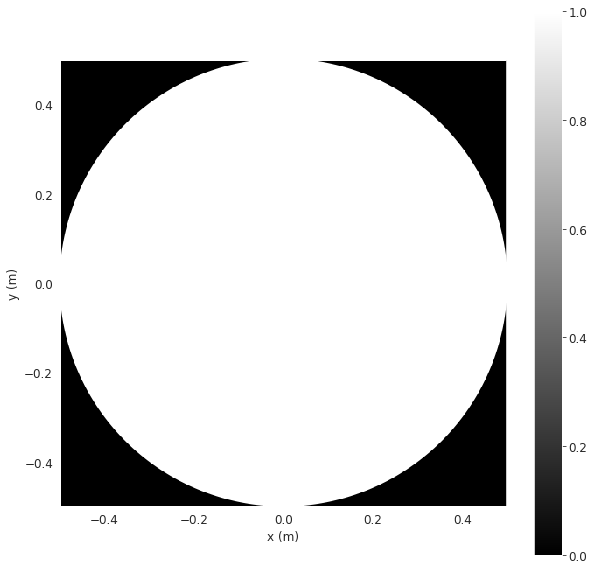

In [ ]:
pupil_diameter           = 1.0 # m

effective_focal_length   = 20 # m

pupil_grid               = make_pupil_grid(512, diameter = pupil_diameter)

aperture                 = circular_aperture(pupil_diameter)

telescope_pupil_off_axis = evaluate_supersampled(aperture , pupil_grid  ,8)

im = imshow_field(telescope_pupil_off_axis, cmap='gray')
plt.colorbar()
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()

In [ ]:
flux = 1

In [ ]:
focal_total = 0

for wavelength in np.linspace(150,300,10)*1e-9:

  amplitude = (flux*wavelength/584490.8382681753)**0.5
  wavefront = Wavefront(amplitude*telescope_pupil_off_axis,wavelength)
  focal_grid = make_focal_grid(q=4, num_airy=64,pupil_diameter=pupil_diameter, focal_length=effective_focal_length, reference_wavelength=wavelength)
  prop = FraunhoferPropagator( pupil_grid, focal_grid, focal_length=effective_focal_length)
  focal_image = prop.forward(wavefront)
  focal_total += focal_image.intensity.shaped

In [ ]:
off_axis = np.array(focal_total/10)
off_axis.sum()

0.24990238028660625

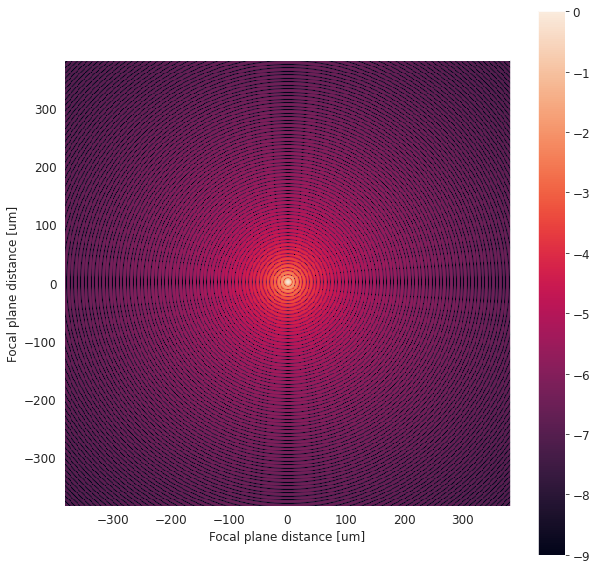

In [ ]:
img = imshow_field(np.log10(focal_image.intensity/focal_image.intensity.max()), vmin=-9, grid_units=1e-6)
plt.xlabel('Focal plane distance [um]')
plt.ylabel('Focal plane distance [um]')
plt.colorbar()
plt.show()

In [ ]:
off_axis.shape

(512, 512)

In [ ]:
plt.plot(off_axis[:,len(off_axis)//2])
plt.yscale('log')

In [ ]:
hdu = fits.PrimaryHDU(off_axis)
hdul = fits.HDUList([hdu])
hdul.writeto(f'off_axis.fits',overwrite=True)

## **Zeemax**

In [ ]:
off_axis_ssr = np.loadtxt('off_axis.TXT', skiprows=18, encoding = 'latin-1')

In [ ]:
off_axis_ssr.max()

1.0

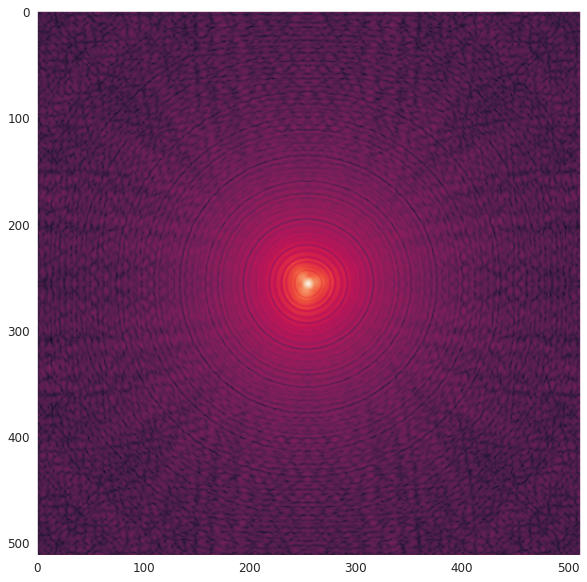

In [ ]:
plt.imshow( np.log10(off_axis_ssr))

In [ ]:
kernel = Gaussian2DKernel(8.5,8.5,x_size=69,y_size=69)
kernel.normalize()
kernel.array.sum()

1.0

In [ ]:
conv_psf = convolve(off_axis_ssr, kernel)
conv_psf.sum()

23.136866287493408

Text(0.5, 1.0, 'Convolved PSF')

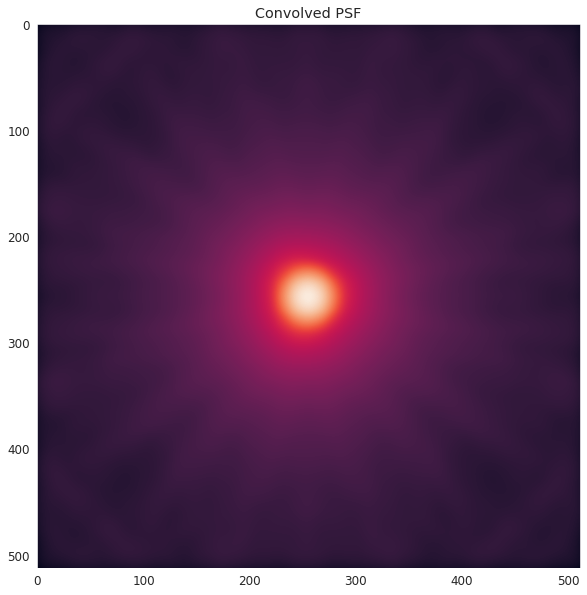

In [ ]:
plt.imshow( np.log10(conv_psf))
plt.title('Convolved PSF')

In [ ]:
flux_p  = conv_psf.max()
i_p,j_p = np.where(conv_psf == flux_p)

coords = []
for i in range(512):
  for j in range(512):
    f = conv_psf[i,j]
    if f>= flux_p/2 and f<=flux_p/2+ flux_p/2*0.01:
      break
  if f>=flux_p/2 and f<=flux_p/2+ flux_p/2*0.01:
    coords.append([i,j,f])
coords = np.array(coords)

Text(0.5, 1.0, 'Pixels coords where the amplitude is in the range max/2 and max/2 + 0.01*max/2')

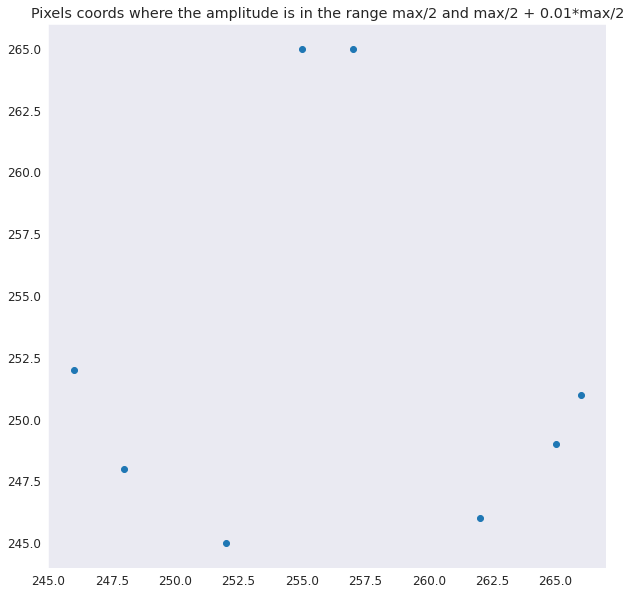

In [ ]:
plt.scatter(coords[:,0],coords[:,1])
plt.title('Pixels coords where the amplitude is in the range max/2 and max/2 + 0.01*max/2')

In [ ]:
dist = np.sqrt ( (coords[:,0]-i_p[0])**2 + (coords[:,1]-j_p[0])**2 )

In [ ]:
FWHM = np.mean(dist)*2
FWHM

21.086042611302233

## **Circular Aperture with obstruction**

In [ ]:
pupil_diameter = 1.0 # m

effective_focal_length = 20 # m

pupil_grid = make_pupil_grid(512, diameter = pupil_diameter)

aperture = make_obstructed_circular_aperture(pupil_diameter,0.36,num_spiders=4,spider_width= 0.025)

telescope_pupil_on_axis = evaluate_supersampled(aperture , pupil_grid  ,8)

im = imshow_field(telescope_pupil_on_axis, cmap='gray')
plt.colorbar()
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()

In [ ]:
flux = 1

In [ ]:
focal_total = 0

for wavelength in np.linspace(150,300,10)*1e-9:

  amplitude = (flux*wavelength/on_axis.sum())**0.5
  wavefront = Wavefront(amplitude*telescope_pupil_on_axis,wavelength)
  focal_grid = make_focal_grid(q=8, num_airy=50,pupil_diameter=pupil_diameter, focal_length=effective_focal_length, reference_wavelength=wavelength)
  prop = FraunhoferPropagator( pupil_grid, focal_grid, focal_length=effective_focal_length)
  focal_image = prop.forward(wavefront)
  focal_total += focal_image.intensity.shaped

In [ ]:
focal_image.amplitude.shaped.shape

In [ ]:
on_axis = np.array(focal_total/10)
on_axis.sum()

In [ ]:
img = imshow_field(np.log10(focal_image.intensity/focal_image.intensity.max()), vmin=-5, grid_units=1e-6)
plt.xlabel('Focal plane distance [um]')
plt.ylabel('Focal plane distance [um]')
plt.colorbar()
plt.show()

In [ ]:
plt.plot(on_axis[:,len(on_axis)//2])
plt.yscale('log')

In [ ]:
hdu = fits.PrimaryHDU(on_axis)
hdul = fits.HDUList([hdu])
hdul.writeto(f'on_axis.fits',overwrite=True)

## **Circular Aperture with New Spider**

In [ ]:
pupil_diameter = 1.0 # m

effective_focal_length = 20 # m

pupil_grid = make_pupil_grid(512, diameter = pupil_diameter)

pupil_outer = circular_aperture(pupil_diameter)(pupil_grid)
pupil_inner = circular_aperture(0.36)(pupil_grid)

pupil_ring = pupil_outer - pupil_inner

aperture = make_obstructed_circular_aperture(pupil_diameter,0.36)

telescope_pupil_off_axis_v2 = evaluate_supersampled(aperture , pupil_grid  ,8)

spiders1= make_spider((0, -0.17), (0.5, -0.17), 0.025)(pupil_grid)
spiders2= make_spider((0.17, 0), (0.17, 0.5), 0.025)(pupil_grid)
spiders3= make_spider((0, 0.17), (-0.5, 0.17), 0.025)(pupil_grid)
spiders4= make_spider((-0.17, 0), (-0.17, -0.5), 0.025)(pupil_grid)

for spider in [spiders1,spiders2,spiders3,spiders4]:
  telescope_pupil_off_axis_v2*=spider*pupil_ring


im = imshow_field(telescope_pupil_off_axis_v2, cmap='gray')
plt.colorbar()
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()

In [ ]:
flux = 1

In [ ]:
focal_total = 0

for wavelength in np.linspace(150,300,10)*1e-9:

  amplitude = (flux*wavelength/474986.6604404929)**0.5
  wavefront = Wavefront(amplitude*telescope_pupil_off_axis_v2,wavelength)
  focal_grid = make_focal_grid(q=8, num_airy=50,pupil_diameter=pupil_diameter, focal_length=effective_focal_length, reference_wavelength=wavelength)
  prop = FraunhoferPropagator( pupil_grid, focal_grid, focal_length=effective_focal_length)
  focal_image = prop.forward(wavefront)
  focal_total += focal_image.intensity.shaped

In [ ]:
focal_image.amplitude.shaped.shape

In [ ]:
on_axis_v2 = np.array(focal_total/10)
on_axis_v2.sum()

In [ ]:
img = imshow_field(np.log10(focal_image.intensity/focal_image.intensity.max()), vmin=-5, grid_units=1e-6)
plt.xlabel('Focal plane distance [um]')
plt.ylabel('Focal plane distance [um]')
plt.colorbar()
plt.show()

In [ ]:
plt.plot(on_axis_v2[:,len(on_axis_v2)//2])
plt.yscale('log')

In [ ]:
fig, ax = plt.subplots(1,3,figsize= (30,10))
ax[0].imshow(on_axis,vmin=1e-9,vmax=1e-5)
ax[0].set_title(f'On Axis | Flux : {np.round(on_axis.sum(),4)} Jy' )
ax[1].imshow(off_axis,vmin=1e-9,vmax=1e-5)
ax[1].set_title(f'Off Axis | Flux : {np.round(off_axis.sum(),4)} Jy')

resid = on_axis- off_axis 
ax[2].imshow(resid,vmin=1e-9,vmax=1e-5)
ax[2].set_title(f'Residual| Flux : {resid.sum()} Jy');

In [ ]:
fig, ax = plt.subplots(1,3,figsize= (30,10))
ax[0].plot(on_axis[:,len(on_axis)//2])
ax[0].set_title(f'On Axis | Flux : {np.round(on_axis.sum(),4)} Jy' )
ax[1].plot(off_axis[:,len(off_axis)//2])
ax[1].set_title(f'Off Axis | Flux : {np.round(off_axis.sum(),4)} Jy')

 
ax[2].plot(on_axis[:,len(on_axis)//2])
ax[2].plot(off_axis[:,len(off_axis)//2])
ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[2].set_yscale('log')

In [ ]:
data = off_axis
positions = [(data.shape[0]//2, data.shape[1]//2)]
aperture = CircularAperture(positions, r=8.)
phot_table = aperture_photometry(data, aperture)
phot_table['aperture_sum'].info.format = '%.8g'  
phot_table

In [ ]:
data = on_axis
positions = [(data.shape[0]//2, data.shape[1]//2)]
aperture = CircularAperture(positions, r=8.)
phot_table = aperture_photometry(data, aperture)
phot_table['aperture_sum'].info.format = '%.8g'  
phot_table

In [ ]:
data = on_axis_v2
positions = [(data.shape[0]//2, data.shape[1]//2)]
aperture = CircularAperture(positions, r=8.)
phot_table = aperture_photometry(data, aperture)
phot_table['aperture_sum'].info.format = '%.8g'  
phot_table

# **Exposure Time Calulator**

In [6]:
df = pd.read_csv('detector_parameters.csv')
df

,filter,wavelength,bandwidth,effective_area,sky_brightness,plate_scale,aperture,dark_current,read_noise
0,UVIT NUV,2418,767,40.000,24.50,1.5,4.50,0.0000,0.0
1,UVIT FUV,1541,372,10.000,25.00,1.5,4.50,0.0000,0.0
2,GALEX NUV,2304,768,44.000,27.00,1.5,15.90,0.0000,0.0
3,GALEX FUV,1549,228,25.000,28.00,1.5,12.60,0.0000,0.0
4,LSST LU,3751,516,110835.400,23.08,0.2,1.80,2.0000,5.0
5,LSST LG,4741,1461,199503.700,21.90,0.2,1.80,2.0000,5.0
6,EUCLID V,6872,3698,4841.756,21.40,0.1,0.45,0.0006,3.6
7,EUCLID VEX,6872,3698,4841.756,21.40,0.1,1.29,0.0006,3.6


In [30]:
for i, row in df.iterrows():
  t = exposure_time(row,16,5.0)
  print(t)

0.015140060919265922
0.07939201112370314
0.013118180454821696
0.051977995855203026
0.00010636645770769221
2.6386179299557333e-05
0.0002502180978623377
0.0006411639075459621


In [27]:
def exposure_time(det_params,M,SNR):
	wavelength     = det_params['wavelength']
	bandwidth      = det_params['bandwidth']
	effective_area = det_params['effective_area']
	M_sky          = det_params['sky_brightness']
	plate_scale    = det_params['plate_scale']
	aperture       = det_params['aperture']
	dark_current   = det_params['dark_current']
	read_noise     = det_params['read_noise']

	F_0_p   = 1.51e3*(bandwidth/wavelength)*3631*effective_area
	F_m_p   = F_0_p*pow(10,-0.4*M)
	M_sky_p = M_sky - 2.5*np.log10(plate_scale**2)
	F_sky_p = F_0_p*pow(10,-0.4*M_sky_p)

	n_pix   = np.pi*((0.5*aperture)/plate_scale)**2

	A =  (F_m_p/SNR)**2
	B = -(F_m_p + F_sky_p*n_pix + dark_current*n_pix)
	C = -n_pix*(read_noise)**2

	t1 = (-B + np.sqrt(B**2 - 4*A*C))/(2*A)
	t2 = (-B - np.sqrt(B**2 - 4*A*C))/(2*A)
 
	if t1>0:
		return t1/60
	else:
		return t1/60

In [24]:
uvit_exptime_nuv(16,5.0)

0.015140060919265922

1042.3050442374076 2676.5312360831877 2854.9666518220674


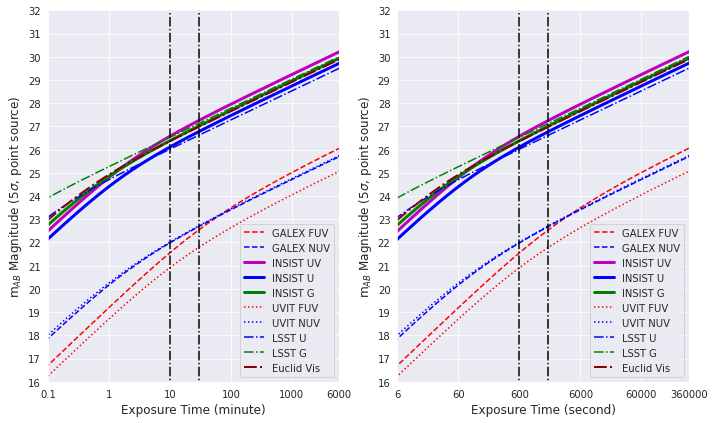

In [12]:
#***********************************************************
def frange(start, stop, step):
	i = start
	while i < stop:
		yield i
		i += step
#***********************************************************
f0 = open("temp0","w")
for i in frange(0, 31, 0.1):
	f0.write('{0:f}\n'.format(i))
f0.close()

#***********************************************************
# UVOT
s_plt_scl		    = 0.502				#Plate Scale
s_RN			      = 0.0				  #Read Noise
s_apr_dia_w2		= 3*2.5				#photometric aperture fwhm (arcsec), FUV
s_apr_dia_m2		= 3*2.5 			#photometric aperture fwhm (arcsec), NUV
s_apr_dia_w1		= 3*2.5				#photometric aperture fwhm (arcsec), FUV
s_apr_dia_u		  = 3*2.5 			#photometric aperture fwhm (arcsec), NUV
s_w2			      = 1				    #Gain, FUV
s_m2			      = 1				    #Gain, NUV
s_w1			      = 1		    		#Gain, FUV
s_u			        = 1   				#Gain, NU1
s_eff_area_w2		= 25.0				#Effective telescope area, FUV
s_eff_area_m2		= 20.0  			#Effective telescope area, NUV
s_eff_area_w1		= 23.0				#Effective telescope area, FUV
s_eff_area_u		= 45.0  

#============================================================	
# GALEX
#https://asd.gsfc.nasa.gov/archive/galex/Documents/GALEX%20GI%20CYCLE4_files/APJS-12-07.pdf
#http://svo2.cab.inta-csic.es/theory/fps/index.php?id=GALEX/GALEX.NUV&&mode=browse&gname=GALEX&gname2=GALEX#filter
#https://www.aanda.org/articles/aa/full_html/2016/12/aa27782-15/F1.html
#http://www.na.astro.it/ACCESS/data_Galex.htm

g_plt_scl		    = 1.5	  			#Plate Scale
g_RN        		= 0.0 				#Read Noise
g_apr_dia_fuv		= 3*4.2 			#photometric aperture fwhm (arcsec), FUV
g_apr_dia_nuv		= 3*5.3 			#photometric aperture fwhm (arcsec), NUV
g_fuv			      = 0.71				#Gain, FUV
g_nuv			      = 0.73				#Gain, NUV
g_eff_area_fuv	= 25.0				#Effective telescope area, FUV
g_eff_area_nuv	= 44.0  			#Effective telescope area, NUV

#============================================================
# INSIST
i_plt_scl		    =  0.15				#Plate Scale
i_RN			      =  3.0				#Read Noise for Gain = 1.0
i_DC			      = 0.1 				#Dark Current (e/p/s)
i_apr_dia_uv		= 3*0.2 			#photometric aperture fwhm (arcsec), UV
i_apr_dia_u		  = 3*0.2 			#photometric aperture fwhm (arcsec), U
i_apr_dia_g		  = 3*0.2 			#photometric aperture fwhm (arcsec), G
i_uv			      = 1.00				#Gain, UV
i_fuv			      = 1.00
i_nuv			      = 1.00
i_u			        = 1.00				#Gain, U
i_g			        = 1.00 				#Gain, G
i_eff_area_uv		= np.pi*(100.0/2)**2*0.80**5*0.90**2*0.50          # (5 mirrors, 2 DF, QE)
i_eff_area_u		= np.pi*(100.0/2)**2*0.90**5*0.90**2*0.95*0.75     # (5 mirrors, 2 DF, 1 Corrector, QE)
i_eff_area_g		= np.pi*(100.0/2)**2*0.90**5*0.90*0.90*0.95*0.80   # (5 mirrors, 1 DF, 1 Corrector, 1 Filter, QE)

i_eff_area_fuv  = np.pi*(100.0/2)**2*0.90**5*0.94**2*0.9*0.50*0.90
i_eff_area_nuv	= np.pi*(100.0/2)**2*0.90**5*0.94**2*0.9*0.50*0.90
print(i_eff_area_uv, i_eff_area_u, i_eff_area_g)

#-------------------------


# LSST
l_plt_scl	     	= 0.2				#Plate Scale
l_RN			      = 5.0				#Read Noise
l_apr_dia_u		  = 3*0.6 		#photometric aperture fwhm (arcsec), NUV
l_u			        = 1.0				#Gain, NUV
l_DC			      = 2.0				#Dark Current
l_eff_area_u		= np.pi*(840.0/2.)**2*0.20  	#Effective telescope area, NUV
l_eff_area_g		= np.pi*(840.0/2.)**2*0.36  	#Effective telescope area, NUV
#***********************************************************

# EUCLID
#https://arxiv.org/pdf/1608.08603.pdf
eu_plt_scl		  = 0.10			#Plate Scale
eu_RN			      = 3.6				#Read Noise
eu_apr_dia_v		= 3*0.15 		#Photometric aperture fwhm (arcsec), 
eu_v			      = 3.7				#Gain, 
eu_DC			= 6e-4				    #Dark Current
eu_eff_area_v		= 0.87*np.pi*(120.0/2.)**2*pow(0.9,4)*0.75  	#Effective telescope area (Filter+QE)
eu_apr_dia_vex	= 3*0.43
#***********************************************************


def uvit_exptime_fuv(Mstar, SNR):
	u_Ffuv_AB_0		          = 1.51e3*(372.0/1541.0)*3631.0
	u_Ffuv_AB_0_ct		      = u_Ffuv_AB_0*u_eff_area_fuv
	u_Ffuv_AB_0_ct_adu	    = u_Ffuv_AB_0_ct
	u_Ffuv_AM_m_adu		      = u_Ffuv_AB_0_ct_adu * pow(10, -0.4*Mstar)
	u_Mfuvsky		            = 25.0 - 2.5 * np.log10(u_plt_scl*u_plt_scl)
	u_Ffuv_AM_sky_adu	      = u_Ffuv_AB_0_ct_adu * pow(10, -0.4*u_Mfuvsky)
	u_n_pix			            = np.pi * ((u_apr_dia_fuv*0.5)/u_plt_scl)**2
	u_Ffuv_AM_sky_adu_tot 	= u_Ffuv_AM_sky_adu * u_n_pix
	u_Ffuv_AM_m_adu_source	= u_Ffuv_AM_m_adu

	A1			= (u_Ffuv_AM_m_adu_source/SNR)**2
	B1			= -(u_Ffuv_AM_m_adu_source + u_Ffuv_AM_sky_adu_tot + u_DC_fuv*u_n_pix)
	C1			= -u_n_pix * (u_RN**2)
	tt1			= (-B1 + np.sqrt(B1**2 - (4* A1 * C1)))/(2*A1)
	tt2			= (-B1 - np.sqrt(B1**2 - (4* A1 * C1)))/(2*A1)
 
	if tt1 > 0:
		return tt1/60.
	else:
		return tt2/60.

def uvit_exptime_nuv(Mstar, SNR):

	u_Fnuv_AB_0	 	          = 1.51e3*(767.0/2418.0)*3631.0
	u_Fnuv_AB_0_ct		      = u_Fnuv_AB_0*u_eff_area_nuv
	u_Fnuv_AB_0_ct_adu	    = u_Fnuv_AB_0_ct
	u_Fnuv_AM_m_adu		      = u_Fnuv_AB_0_ct_adu * pow(10, -0.4*Mstar)
	u_Mnuvsky		            = 24.5 - 2.5 * np.log10(u_plt_scl*u_plt_scl)
	u_Fnuv_AM_sky_adu	      = u_Fnuv_AB_0_ct_adu * pow(10, -0.4*u_Mnuvsky)
	u_n_pix			            = np.pi * ((u_apr_dia_nuv*0.5)/u_plt_scl)**2
	u_Fnuv_AM_sky_adu_tot	  = u_Fnuv_AM_sky_adu * u_n_pix
	u_Fnuv_AM_m_adu_source	= u_Fnuv_AM_m_adu

	A1			                = (u_Fnuv_AM_m_adu/SNR)**2
	B1			                = -(u_Fnuv_AM_m_adu_source + u_Fnuv_AM_sky_adu_tot + u_DC_nuv*u_n_pix)
	C1			                = -u_n_pix * (u_RN**2)
	tt1			                = (-B1 + np.sqrt(B1**2 - (4* A1 * C1)))/(2*A1)
	tt2			                = (-B1 - np.sqrt(B1**2 - (4* A1 * C1)))/(2*A1)
 
	if tt1 > 0:
		return tt1/60.
	else:
		return tt2/60.

def galex_exptime_fuv(Mstar, SNR):
	g_Ffuv_AB_0		          = 1.51e3*(228.0/1549.0)*3631.0
	g_Ffuv_AB_0_ct		      = g_Ffuv_AB_0*g_eff_area_fuv
	g_Ffuv_AB_0_ct_adu	    = g_Ffuv_AB_0_ct
	g_Ffuv_AM_m_adu		      = g_Ffuv_AB_0_ct_adu * pow(10, -0.4*Mstar)
	g_Mfuvsky		            = 28.80 - 2.5 * np.log10(g_plt_scl*g_plt_scl)
	g_Ffuv_AM_sky_adu	      = g_Ffuv_AB_0_ct_adu * pow(10, -0.4*g_Mfuvsky)
	g_n_pix			            = np.pi * ((g_apr_dia_fuv*0.5)/g_plt_scl)**2
	g_Ffuv_AM_sky_adu_tot	  = g_Ffuv_AM_sky_adu * g_n_pix
	g_Ffuv_AM_m_adu_source	= g_Ffuv_AM_m_adu
	A1			                = (g_Ffuv_AM_m_adu_source/SNR)**2
	B1			                = -(g_Ffuv_AM_m_adu_source + g_Ffuv_AM_sky_adu_tot)
	C1			                = -g_n_pix * (g_RN**2)
	tt1			                = (-B1 + np.sqrt(B1**2 - (4* A1 * C1)))/(2*A1)
	tt2			                = (-B1 - np.sqrt(B1**2 - (4* A1 * C1)))/(2*A1)
	if tt1 > 0:
		return tt1/60.
	else:
		return tt2/60.

def galex_exptime_nuv(Mstar, SNR):
	g_Fnuv_AB_0		         = 1.51e3*(768.0/2304.7)*3631.0
	g_Fnuv_AB_0_ct		     = g_Fnuv_AB_0*g_eff_area_nuv
	g_Fnuv_AB_0_ct_adu	   = g_Fnuv_AB_0_ct 
	g_Fnuv_AM_m_adu		     = g_Fnuv_AB_0_ct_adu * pow(10, -0.4*Mstar)
	g_Mnuvsky		           = 27.0 - 2.5 * np.log10(g_plt_scl*g_plt_scl)
	g_Fnuv_AM_sky_adu	     = g_Fnuv_AB_0_ct_adu * pow(10, -0.4*g_Mnuvsky)
	g_n_pix			           = np.pi * ((g_apr_dia_nuv*0.5)/g_plt_scl)**2
	A1			               = ((g_Fnuv_AM_m_adu)/SNR)**2
	B1		 	               = -((g_Fnuv_AM_m_adu) + g_Fnuv_AM_sky_adu*g_n_pix)
	C1			               = -g_n_pix * (g_RN**2 +(g_nuv/2)**2)
	tt1			               =  (-B1 + np.sqrt(B1**2 - (4* A1 * C1)))/(2*A1)
	tt2			               =  (-B1 - np.sqrt(B1**2 - (4* A1 * C1)))/(2*A1)
	if tt1 > 0:
		return tt1/60.
	else:
		return tt2/60.

def insist_exptime_uv(Mstar, SNR):
	i_uv_AB_0		           = 1.51e3*(1500.0/2250.0)*3631.0
	i_uv_AB_0_ct		       = i_uv_AB_0 * i_eff_area_uv
	i_uv_AB_0_ct_adu	     = i_uv_AB_0_ct
	i_uv_AM_m_adu		       = i_uv_AB_0_ct_adu * pow(10, -0.4*Mstar)*np.sqrt(3)
	i_Muvsky		           = 27.5 - 2.5 * np.log10(i_plt_scl*i_plt_scl)
	i_uv_AM_sky_adu		     = i_uv_AB_0_ct_adu * pow(10, -0.4*i_Muvsky)
	i_n_pix			           = np.pi * ((i_apr_dia_uv*0.5)/i_plt_scl)**2
	A1			               = (i_uv_AM_m_adu*np.sqrt(3)/SNR)**2
	B1			               = -(i_uv_AM_m_adu*np.sqrt(3) + i_uv_AM_sky_adu*i_n_pix+i_DC*i_n_pix)
	C1			               = -(i_n_pix * i_RN**2)
	tt1			               =  (-B1 + np.sqrt(B1**2 - (4* A1 * C1)))/(2*A1)
	tt2			               =  (-B1 - np.sqrt(B1**2 - (4* A1 * C1)))/(2*A1)
	if tt1 > 0:
		return tt1/60.
	else:
		return tt2/60.

def insist_exptime_fuv(Mstar, SNR):
	i_fuv_AB_0		         = 1.51e3*(750.0/1875.0)*3631.0
	i_fuv_AB_0_ct		       = i_fuv_AB_0*i_eff_area_fuv 
	i_fuv_AB_0_ct_adu	     = i_fuv_AB_0_ct
	i_fuv_AM_m_adu		     = i_fuv_AB_0_ct_adu * pow(10, -0.4*Mstar)
	i_Mfuvsky		           = 30.0 - 2.5 * np.log10(i_plt_scl*i_plt_scl)
	i_fuv_AM_sky_adu	     = i_fuv_AB_0_ct_adu * pow(10, -0.4*i_Mfuvsky)
	i_n_pix			           = np.pi * ((i_apr_dia_uv*0.5)/i_plt_scl)**2
	A1			               = (i_fuv_AM_m_adu*np.sqrt(3)/SNR)**2
	B1			               = -(i_fuv_AM_m_adu * np.sqrt(3) + i_fuv_AM_sky_adu*i_n_pix+i_DC*i_n_pix)
	C1			               = -i_n_pix * (i_RN**2)
	tt1			               =   (-B1 + np.sqrt(B1**2 - (4* A1 * C1)))/(2*A1)
	tt2			               =   (-B1 - np.sqrt(B1**2 - (4* A1 * C1)))/(2*A1)
	if tt1 > 0:
		return tt1/60.
	else:
		return tt2/60.

def insist_exptime_nuv(Mstar, SNR):
	i_nuv_AB_0		        = 1.51e3*(750.0/2625.0)*3631.0
	i_nuv_AB_0_ct		      = i_nuv_AB_0*i_eff_area_nuv
	i_nuv_AB_0_ct_adu	    = i_nuv_AB_0_ct
	i_nuv_AM_m_adu		    = i_nuv_AB_0_ct_adu * pow(10, -0.4*Mstar)
	i_Mnuvsky		          = 25.5 - 2.5 * np.log10(i_plt_scl*i_plt_scl)
	i_nuv_AM_sky_adu	    = i_nuv_AB_0_ct_adu * pow(10, -0.4*i_Mnuvsky)
	i_n_pix			          = np.pi * ((i_apr_dia_uv*0.5)/i_plt_scl)**2
	A1			              = (i_nuv_AM_m_adu*np.sqrt(3)/SNR)**2
	B1			              = -(i_nuv_AM_m_adu*np.sqrt(3) + i_nuv_AM_sky_adu*i_n_pix+i_DC*i_n_pix)
	C1			              = -i_n_pix * (i_RN**2)
	tt1			              =  (-B1 + np.sqrt(B1**2 - (4* A1 * C1)))/(2*A1)
	tt2			              =  (-B1 - np.sqrt(B1**2 - (4* A1 * C1)))/(2*A1)
	if tt1 > 0:
		return tt1/60.
	else:
		return tt2/60.

def insist_exptime_u(Mstar, SNR):
	i_Fu_AB_0		         = 1.51e3*(700.0/3641.0)*3631.0 #LSST u-filter http://svo2.cab.inta-csic.es/theory/fps/
	i_Fu_AB_0_ct		     = i_Fu_AB_0*i_eff_area_u
	i_Fu_AB_0_ct_adu	   = i_Fu_AB_0_ct 
	i_Fu_AM_m_adu		     = i_Fu_AB_0_ct_adu * pow(10, -0.4*Mstar)*np.sqrt(3)
	i_Musky			         = 23.08 - 2.5 * np.log10(i_plt_scl*i_plt_scl)
	i_Fu_AM_sky_adu		   = i_Fu_AB_0_ct_adu * pow(10, -0.4*i_Musky)
	i_n_pix			         = np.pi * ((i_apr_dia_u*0.5)/i_plt_scl)**2
	i_Dcu_t			         = i_DC*i_n_pix
	A1		               = (i_Fu_AM_m_adu*np.sqrt(3)/SNR)**2
	B1			             = -(i_Fu_AM_m_adu*np.sqrt(3) + i_Fu_AM_sky_adu*i_n_pix+i_DC*i_n_pix)
	C1			             = -i_n_pix * (i_RN**2 + (i_u/2)**2)
	tt1			             =  (-B1 + np.sqrt(B1**2 - (4* A1 * C1)))/(2*A1)
	tt2			             =  (-B1 - np.sqrt(B1**2 - (4* A1 * C1)))/(2*A1)
	if tt1 > 0:
		return tt1/60.
	else:
		return tt2/60.

def insist_exptime_g(Mstar, SNR):
	i_Fg_AB_0		        = 1.51e3*(1523.0/4705.0)*3631.0 #LSST g-filter http://svo2.cab.inta-csic.es/theory/fps/
	i_Fg_AB_0_ct		    = i_Fg_AB_0*i_eff_area_g
	i_Fg_AB_0_ct_adu	  = i_Fg_AB_0_ct 
	i_Fg_AM_m_adu		    = i_Fg_AB_0_ct_adu * pow(10, -0.4*Mstar)*np.sqrt(3)
	i_Mgsky			        = 21.9 - 2.5 * np.log10(i_plt_scl*i_plt_scl)
	i_Fg_AM_sky_adu		  = i_Fg_AB_0_ct_adu * pow(10, -0.4*i_Mgsky)
	i_n_pix			        = np.pi * ((i_apr_dia_g*0.5)/i_plt_scl)**2
	i_Dcu_t			        = i_DC*i_n_pix
	A1		            	= (i_Fg_AM_m_adu*np.sqrt(3)/SNR)**2
	B1			            = -(i_Fg_AM_m_adu*np.sqrt(3) + i_Fg_AM_sky_adu*i_n_pix + i_DC*i_n_pix)
	C1			            = -i_n_pix * (i_RN**2)
	tt1			            = (-B1 + np.sqrt(B1**2 - (4* A1 * C1)))/(2*A1)
	tt2			            = (-B1 - np.sqrt(B1**2 - (4* A1 * C1)))/(2*A1)
	if tt1 > 0:
		return tt1/60.
	else:
		return tt2/60.

def insist_exptime_gex(Mstar, SNR):
	i_Fgex_AB_0		      = 1.51e3*(1500.0/4750.0)*3631.0
	i_Fgex_AB_0_ct		  = i_Fgex_AB_0*i_eff_area_g
	i_Fgex_AB_0_ct_adu	= i_Fgex_AB_0_ct * np.sqrt(3.0)
	i_Fgex_AM_m_adu		  = i_Fgex_AB_0_ct_adu * pow(10, -0.4*Mstar)
	i_Mgexsky		        = 22.5 - 2.5 * np.log10(i_plt_scl*i_plt_scl)
	i_Fgex_AM_sky_adu	  = i_Fgex_AB_0_ct_adu * pow(10, -0.4*i_Mgexsky)
	i_apr_dia_gex		    = 3*0.60
	i_exn_pix		        = np.pi * ((i_apr_dia_gex*0.5)/i_plt_scl)**2
	A1			            = (i_Fgex_AM_m_adu/SNR)**2
	B1			            = -(i_Fgex_AM_m_adu + i_Fgex_AM_sky_adu*i_exn_pix + i_DC*i_exn_pix)
	C1			            = -i_exn_pix * (i_RN**2)
	tt1			            = (-B1 + np.sqrt(B1**2 - (4* A1 * C1)))/(2*A1)
	tt2			            = (-B1 - np.sqrt(B1**2 - (4* A1 * C1)))/(2*A1)
	if tt1 > 0:
		return tt1/60.
	else:
		return tt2/60.
#***********************************************************
def lsst_exptime_lu(Mstar, SNR):
	l_Fu_AB_0		       = 1.51e3*(516.7/3751.0)*3631.0
	l_Fu_AB_0_ele		   = l_Fu_AB_0 * l_eff_area_u
	l_Fu_AM_m_ele		   = l_Fu_AB_0_ele * pow(10, -0.4*Mstar)
	l_Mlusky		       = 23.08 - 2.5 * np.log10(l_plt_scl*l_plt_scl)
	l_Fu_AM_sky_ele		 = l_Fu_AB_0_ele * pow(10, -0.4*l_Mlusky)
	l_n_pix			       = np.pi * ((l_apr_dia_u*0.5)/l_plt_scl)**2
	l_RN_adu		       = l_n_pix * (l_RN**2)
	A1			           = (l_Fu_AM_m_ele/SNR)**2
	B1			           = -(l_Fu_AM_m_ele + l_Fu_AM_sky_ele * l_n_pix + l_DC * l_n_pix)
	C1			           = -l_n_pix * (l_RN**2)
	tt1			           = (-B1 + np.sqrt(B1**2 - (4* A1 * C1)))/(2*A1)
	tt2			           = (-B1 - np.sqrt(B1**2 - (4* A1 * C1)))/(2*A1)
	if tt1 > 0:
		return tt1/60.
	else:
		return tt2/60.

def lsst_exptime_lg(Mstar, SNR):
	l_Fg_AB_0		       = 1.51e3*(1461.7/4741.0)*3631.0
	l_Fg_AB_0_ele		   = l_Fg_AB_0 * l_eff_area_g
	l_Fg_AM_m_ele		   = l_Fg_AB_0_ele * pow(10, -0.4*Mstar)
	l_Mlgsky		       = 21.9 - 2.5 * np.log10(l_plt_scl*l_plt_scl)
	l_Fg_AM_sky_ele		 = l_Fg_AB_0_ele * pow(10, -0.4*l_Mlgsky)
	l_n_pix			       = np.pi * ((l_apr_dia_u*0.5)/l_plt_scl)**2
	A1			           = (l_Fg_AM_m_ele/SNR)**2
	B1			           = -(l_Fg_AM_m_ele + l_Fg_AM_sky_ele * l_n_pix + l_DC * l_n_pix)
	C1			           = -l_n_pix * (l_RN**2)
	tt1			           = (-B1 + np.sqrt(B1**2 - (4* A1 * C1)))/(2*A1)
	tt2			           = (-B1 - np.sqrt(B1**2 - (4* A1 * C1)))/(2*A1)
	if tt1 > 0:
		return tt1/60.
	else:
		return tt2/60.

def eu_exptime_v(Mstar, SNR):
	eu_Fv_AB_0		     = 1.51e3*(3698.9/6872.0)*3631.0
	eu_Fv_AB_0_ele		 = eu_Fv_AB_0 * eu_eff_area_v *np.sqrt(3)
	eu_Fv_AM_m_ele		 = eu_Fv_AB_0_ele * pow(10, -0.4*Mstar)
	eu_Meuvsky		     = 21.4 - 2.5 * np.log10(eu_plt_scl*eu_plt_scl)
	eu_Fv_AM_sky_ele	 = eu_Fv_AB_0_ele * pow(10, -0.4*eu_Meuvsky)
	eu_n_pix		       = np.pi * ((eu_apr_dia_v*0.5)/eu_plt_scl)**2
	A1			           = (eu_Fv_AM_m_ele/SNR)**2
	B1			           = -(eu_Fv_AM_m_ele + eu_Fv_AM_sky_ele * eu_n_pix + eu_DC * eu_n_pix)
	C1			           = -eu_n_pix * (eu_RN**2)
	tt1			           = (-B1 + np.sqrt(B1**2 - (4* A1 * C1)))/(2*A1)
	tt2			           = (-B1 - np.sqrt(B1**2 - (4* A1 * C1)))/(2*A1)
	if tt1 > 0:
		return tt1/60.
	else:
		return tt2/60.

def eu_exptime_vex(Mstar, SNR):
	eu_Fvex_AB_0		    = 1.51e3*(3698.9/6872.0)*3631.0
	eu_Fvex_AB_0_ele	  = eu_Fvex_AB_0 * eu_eff_area_v * np.sqrt(3)
	eu_Fvex_AM_m_ele	  = eu_Fvex_AB_0_ele * pow(10, -0.4*Mstar)
	eu_Meuvexsky		    = 21.4 - 2.5 * np.log10(eu_plt_scl*eu_plt_scl)
	eu_Fvex_AM_sky_ele	= eu_Fvex_AB_0_ele * pow(10, -0.4*eu_Meuvexsky)
	eu_exn_pix		      = np.pi * ((eu_apr_dia_vex*0.5)/eu_plt_scl)**2
	A1			            = (eu_Fvex_AM_m_ele/SNR)**2
	B1			            = -(eu_Fvex_AM_m_ele + eu_Fvex_AM_sky_ele * eu_exn_pix + eu_DC * eu_exn_pix)
	C1			            = -eu_exn_pix * (eu_RN**2)
	tt1			            = (-B1 + np.sqrt(B1**2 - (4* A1 * C1)))/(2*A1)
	tt2			            = (-B1 - np.sqrt(B1**2 - (4* A1 * C1)))/(2*A1)
	if tt1 > 0:
		return tt1/60.
	else:
		return tt2/60.
#***********************************************************
UVmag	= np.loadtxt('temp0',unpack=True)
f1 = open("pointsource.mag","w")
for i in range(len(UVmag)):
	galex_exp_FUV	= galex_exptime_fuv(UVmag[i], 5.0)
	galex_exp_NUV	= galex_exptime_nuv(UVmag[i], 5.0)
	insist_exp_UV	= insist_exptime_uv(UVmag[i], 5.0)
	insist_exp_FUV	= insist_exptime_fuv(UVmag[i], 5.0)
	insist_exp_NUV	= insist_exptime_nuv(UVmag[i], 5.0)
	insist_exp_U	= insist_exptime_u(UVmag[i], 5.0)
	insist_exp_G	= insist_exptime_g(UVmag[i], 5.0)
	insist_exp_Gex	= insist_exptime_gex(UVmag[i], 10.0)
	uvit_exp_FUV	= uvit_exptime_fuv(UVmag[i], 5.0)
	uvit_exp_NUV	= uvit_exptime_nuv(UVmag[i], 5.0)
	lsst_exp_u	= lsst_exptime_lu(UVmag[i], 5.0)
	lsst_exp_g	= lsst_exptime_lg(UVmag[i], 5.0)
	eu_exp_v	= eu_exptime_v(UVmag[i], 5.0)
	eu_exp_vex	= eu_exptime_vex(UVmag[i], 10.0)
	f1.write('{0:f}\t{1:f}\t{2:f}\t{3:f}\t{4:f}\t{5:f}\t{6:f}\t{7:f}\t{8:f}\t{9:f}\t{10:f}\t{11:f}\t{12:f}\t{13:f}\t{14:f}\n'.format(UVmag[i], galex_exp_FUV, galex_exp_NUV, insist_exp_UV, insist_exp_FUV, insist_exp_NUV, insist_exp_U, insist_exp_G, insist_exp_Gex, uvit_exp_FUV, uvit_exp_NUV,lsst_exp_u, lsst_exp_g, eu_exp_v, eu_exp_vex))
f1.close()
#***********************************************************
UVmag1, galex_exp_FUV1, galex_exp_NUV1, insist_exp_UV1, insist_exp_FUV1, insist_exp_NUV1, insist_exp_U1, insist_exp_G1, insist_exp_Gex1, uvit_exp_FUV1, uvit_exp_NUV1,lsst_exp_u1, lsst_exp_g1, eu_exp_v1, eu_exp_vex1	= np.loadtxt('pointsource.mag',unpack=True)
#***********************************************************
gs = plt.subplots(figsize=(10, 6))
gs = gridspec.GridSpec(1, 2)
gs.update(left=0.06, right=0.95, top=0.95, bottom=0.09, wspace=0.2, hspace=0.2)
#***********************************************************
ax = plt.subplot(gs[0, 0]) # row 0, col 1
plt.plot(galex_exp_FUV1, UVmag1, '--r', label="GALEX FUV")
plt.plot(galex_exp_NUV1, UVmag1, '--b', label="GALEX NUV")
plt.plot(insist_exp_UV1, UVmag1, '-m', linewidth=3, label="INSIST UV")
#plt.plot(insist_exp_FUV1, UVmag1, '-r', label="INSIST FUV")
#plt.plot(insist_exp_NUV1, UVmag1, '-b', label="INSIST NUV")
plt.plot(insist_exp_U1, UVmag1, '-b', linewidth=3, label="INSIST U")
plt.plot(insist_exp_G1, UVmag1, '-g', linewidth=3, label="INSIST G")
plt.plot(uvit_exp_FUV1, UVmag1, ':r', label="UVIT FUV")
plt.plot(uvit_exp_NUV1, UVmag1, ':b', label="UVIT NUV")
plt.plot(lsst_exp_u1, UVmag1, '-.b', label="LSST U")
plt.plot(lsst_exp_g1, UVmag1, '-.g', label="LSST G")
plt.plot(eu_exp_v1, UVmag1, '-.', color='#880000', linewidth=2, label="Euclid Vis")
#plt.plot(eu_exp_vex1, UVmag1, '-.', color='#800000', linewidth=2, label="Euclid Vis")


ylabel = [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
labels = ['16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32']
plt.yticks(ylabel, labels)

#plt.plot([2.0, 2.0], [0.0, 50.0], '-.k')
plt.plot([10.0, 10.0], [0.0, 50.0], '-.k')
plt.plot([30.0, 30.0], [0.0, 50.0], '-.k')

plt.xlabel('Exposure Time (minute)', fontsize=12)
plt.ylabel(r'm$_{AB}$ Magnitude (5$\sigma$, point source)', fontsize=12)

plt.grid(True)
plt.ylim(16.0, 32.0)
plt.xlim(0.1, 6000.0)
plt.xscale('log')
xlabel = [0.1, 1, 10, 100, 1000, 6000]
labels = ['0.1', '1', '10', '100', '1000', '6000']
plt.xticks(xlabel, labels)
plt.legend()
#-----------------------------------------------------------------------
ax = plt.subplot(gs[0, 1]) # row 0, col 1
plt.plot(galex_exp_FUV1*60.0, UVmag1, '--r', label="GALEX FUV")
plt.plot(galex_exp_NUV1*60.0, UVmag1, '--b', label="GALEX NUV")
plt.plot(insist_exp_UV1*60.0, UVmag1, '-m', linewidth=3, label="INSIST UV")
#plt.plot(insist_exp_FUV1*60.0, UVmag1, '-r', label="INSIST FUV")
#plt.plot(insist_exp_NUV1*60.0, UVmag1, '-b', label="INSIST NUV")
plt.plot(insist_exp_U1*60, UVmag1, '-b', linewidth=3, label="INSIST U")
plt.plot(insist_exp_G1*60, UVmag1, '-g', linewidth=3, label="INSIST G")
plt.plot(uvit_exp_FUV1*60.0, UVmag1, ':r', label="UVIT FUV")
plt.plot(uvit_exp_NUV1*60.0, UVmag1, ':b', label="UVIT NUV")
plt.plot(lsst_exp_u1*60.0, UVmag1, '-.b', label="LSST U")
plt.plot(lsst_exp_g1*60.0, UVmag1, '-.g', label="LSST G")
plt.plot(eu_exp_v1*60.0, UVmag1, '-.', color='#880000', linewidth=2, label="Euclid Vis")
#plt.plot(eu_exp_vex1*60.0, UVmag1, '-.', color='#800000', linewidth=2, label="Euclid Vis")

ylabel = [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
labels = ['16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32']
plt.yticks(ylabel, labels)

#plt.plot([2.0, 2.0], [0.0, 50.0], '-.k')
plt.plot([600.0, 600.0], [0.0, 50.0], '-.k')
plt.plot([1800.0, 1800.0], [0.0, 50.0], '-.k')

plt.xlabel('Exposure Time (second)', fontsize=12)
plt.ylabel(r'm$_{AB}$ Magnitude (5$\sigma$, point source)', fontsize=12)
plt.grid(True)
plt.ylim(16.0, 32.0)
plt.xlim(6.0, 360000.0)
plt.xscale('log')
xlabel = [6, 60, 600, 6000, 60000, 360000]
labels = ['6', '60', '600', '6000', '60000', '360000']
plt.xticks(xlabel, labels)
plt.legend()
plt.savefig('etcplot_galex+lsst+euclid+insist.png')
plt.show()

